<a href="https://colab.research.google.com/github/SimonOuellet/saradsm2/blob/colab/Notebooks/kine-classifier-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas-profiling

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_profiling
import glob
from matplotlib.colors import cnames
from bokeh.plotting import figure, ColumnDataSource, show, output_notebook, output_file
from bokeh.models import HoverTool
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from google.cloud import bigquery
import csv
import os
import warnings
warnings.filterwarnings(action='ignore')
output_notebook()
%matplotlib inline
#%matplotlib widget
from google.cloud import bigquery
from google.colab import auth
auth.authenticate_user()

# Étape I : Pré-analyse Features Engineering

## Chargement des fontions

In [24]:
font_size = 3
def get_float_list(range_max:int, div:int=100) -> list:
    """ To get 0 -> 1, range_max must be same order of mag as div """
    return [float(x)/div for x in range(int(range_max))]


def get_colorcycle(colordict:dict):
    """ Subset cnames with a string match and get a color cycle for plotting """
    return cycle(list(colordict.keys()))


def get_colordict(filter_:str='dark') -> dict:
    """ return dictionary of colornames by filter """
    return dict((k, v) for k, v in cnames.items() if filter_ in k)


def pca_report_interactive(X, scale_X:bool=True, save_plot:bool=False):
    """
    X:          input data matrix
    scale_X:    determine whether to rescale X (StandardScaler) [default: True, X is not prescaled
    save_plot:  save plot to file (html) and not show
    """

    # calculate mean and var
    X_mean, X_var = X.mean(), X.var()
    print('\n*--- PCA Report ---*\n')
    print(f'X mean:\t\t{X_mean:.3f}\nX variance:\t{X_var:.3f}')

    if scale_X:
        # rescale and run PCA
        print("\n...Rescaling data...\n")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_s_mean, X_s_var = X_scaled.mean(), X_scaled.var()
        print(f'X_scaled mean:\t\t{np.round(X_s_mean):.3f}')
        print(f'X_scaled variance:\t{np.round(X_s_var):.3f}\n')
        pca_ = PCA().fit(X_scaled)
        X_pca = PCA().fit_transform(X)
    else:
        # run PCA directly
        print("...Assuming data is properly scaled...")
        pca_ = PCA().fit(X)
        X_pca = PCA().fit_transform(X)
            
    # Get cumulative explained variance for each dimension
    pca_evr = pca_.explained_variance_ratio_
    cumsum_ = np.cumsum(pca_evr)
    
    # Get dimensions where var >= 95% and values for variance at 2D, 3D
    dim_95 = np.argmax(cumsum_ >= 0.95) + 1
    twoD = np.round(cumsum_[1], decimals=3)*100 
    threeD = np.round(cumsum_[2], decimals=3)*100
    instances_, dims_ =  X.shape
    
    # check shape of X
    if dims_ > instances_:
        print("WARNING: number of features greater than number of instances.")
        dimensions = list(range(1, instances_+1))
    else:
        dimensions = list(range(1, dims_+1))
    
    # Print report
    print("\n -- Summary --")
    print(f"You can reduce from {dims_} to {dim_95} dimensions while retaining 95% of variance.")
    print(f"2 principal components explain {twoD:.2f}% of variance.")
    print(f"3 principal components explain {threeD:.2f}% of variance.")
    
    """ - Plotting - """
    # Create custom HoverTool -- we'll name each ROC curve 'ROC' so we only see info on hover there
    hover_ = HoverTool(names=['PCA'], tooltips=[("dimensions", "@x_dim"), 
                                                ("cumulative variance", "@y_cumvar"),
                                                ("explained variance", "@y_var")])
    p_tools = [hover_, 'crosshair', 'zoom_in', 'zoom_out', 'save', 'reset', 'tap', 'box_zoom']

    # insert 0 at beginning for cleaner plotting
    cumsum_plot = np.insert(cumsum_, 0, 0) 
    pca_evr_plot = np.insert(pca_evr, 0, 0)
    dimensions_plot = np.insert(dimensions, 0, 0)

    """
    ColumnDataSource
    - a special type in Bokeh that allows you to store data for plotting
    - store data as dict (key:list)
    - to plot two keys against one another, make sure they're the same length!
    - below:
        x_dim    # of dimensions (length = # of dimensions)
        y_cumvar # cumulative variance (length = # of dimensions)
        var_95   # y = 0.95 (length = # of dimensions)
        zero_one # list of 0 to 1
        twoD     # x = 2 
        threeD   # x = 3 
    """ 
    
    # get sources
    source_PCA = ColumnDataSource(data=dict(x_dim = dimensions_plot,y_cumvar = cumsum_plot, y_var = pca_evr_plot))    
    source_var95 = ColumnDataSource(data=dict(var95_x = [dim_95]*96, var95_y = get_float_list(96)))
    source_twoD = ColumnDataSource(data=dict(twoD_x = [2]*(int(twoD)+1), twoD_y = get_float_list(twoD+1)))
    source_threeD = ColumnDataSource(data=dict(threeD_x = [3]*(int(threeD)+1), threeD_y = get_float_list(threeD+1)))

    """ PLOT """
    # set up figure and add axis labels
    p = figure(title='PCA Analysis', tools=p_tools)
    p.xaxis.axis_label = f'N of {dims_} Principal Components' 
    p.yaxis.axis_label = 'Variance Explained (per PC & Cumulative)'
    
    # add reference lines: y=0.95, x=2, x=3
    p.line('twoD_x', 'twoD_y', line_width=0.5, line_dash='dotted', color='#435363', source=source_twoD) # x=2
    p.line('threeD_x', 'threeD_y', line_width=0.5, line_dash='dotted', color='#435363', source=source_threeD) # x=3
    p.line('var95_x', 'var95_y', line_width=2, line_dash='dotted', color='#435363', source=source_var95) # var = 0.95

    # add bar plot for variance per dimension
    p.vbar(x='x_dim', top='y_var', width=.5, bottom=0, color='#D9F2EF', source=source_PCA, name='PCA')
    
    # add cumulative variance (scatter + line)
    p.line('x_dim', 'y_cumvar', line_width=1, color='#F79737', source=source_PCA)
    p.circle('x_dim', 'y_cumvar', size=7, color='#FF4C00', source=source_PCA, name='PCA')

    # change gridlines
    p.ygrid.grid_line_alpha = 0.25
    p.xgrid.grid_line_alpha = 0.25

    # change axis bounds and grid
    p.xaxis.bounds = (0, dims_)
    p.yaxis.bounds = (0, 1)
    p.grid.bounds = (0, dims_)
    
    plt.rcParams.update({'font.size': font_size})
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)  # fontsize of the figure title

    # save and show p
    if save_plot:
        output_file('PCA_analysis.html')
    show(p)
        
    # output PCA info as a dataframe
    df_PCA = pd.DataFrame({'dimension': dimensions, 'variance_cumulative': cumsum_, 'variance': pca_evr}).set_index(['dimension'])
        
    return df_PCA, X_pca, pca_evr


def pca_feature_correlation(X, X_pca, explained_var, features:list=None, fig_dpi:int=150, save_plot:bool=False):
    """
    1. Get dot product of X and X_pca
    2. Run normalizations of X*X_pca
    3. Retrieve df/matrices

    X:               data (numpy matrix)
    X_pca:           PCA
    explained_var:   explained variance matrix
    features:        list of feature names
    fig_dpi:         dpi to use for heatmaps
    save_plot:       save plot to file (html) and not show
    """
    
    # Add zeroes for data where features > instances
    outer_diff = X.T.shape[0] - X_pca.shape[1]
    if outer_diff > 0: # outer dims must match to get sq matrix
        Z = np.zeros([X_pca.shape[0], outer_diff])
        X_pca = np.c_[X_pca, Z]
        explained_var = np.append(explained_var, np.zeros(outer_diff))
    
    # Get correlation between original features (X) and PCs (X_pca)
    dot_matrix = np.dot(X.T, X_pca)
    print(f"X*X_pca: {X.T.shape} * {X_pca.shape} = {dot_matrix.shape}")
    
    # Correlation matrix -> df
    df_dotproduct = pd.DataFrame(dot_matrix)
    df_dotproduct.columns = [''.join(['PC', f'{i+1}']) for i in range(dot_matrix.shape[0])]
    if any(features): df_dotproduct.index = features    
    
    # Normalize & Sort
    df_n, df_na, df_nabv = normalize_dataframe(df_dotproduct, explained_var, plot_opt=True, save_plot=save_plot)
    
    return df_dotproduct, df_n, df_na, df_nabv


def normalize_dataframe(df, explained_var=None, fig_dpi:int=150, plot_opt:bool=True, save_plot:bool=False):
    """
    1. Get z-normalized df (normalized to µ=0, σ=1)
    2. Get absolute value of z-normalized df
    3. If explained_variance matrix provided, dot it w/ (2)
    """
    # Normalize, Reindex, & Sort
    df_norm = (df.copy()-df.mean())/df.std()
    df_norm = df_norm.sort_values(list(df_norm.columns), ascending=False)
    
    # Absolute value of normalized (& sort)
    df_abs = df_norm.copy().abs().set_index(df_norm.index)
    df_abs = df_abs.sort_values(by=list(df_abs.columns), ascending=False)
    
    # Plot
    if plot_opt:
        # Z-normalized corr matrix
        plt.figure(dpi=fig_dpi)
        ax_normal = sns.heatmap(df_norm, cmap="RdBu")
        ax_normal.set_title("Z-Normalized Data")
        plt.rcParams.update({'font.size': font_size})
        plt.rc('font', size=font_size)          # controls default text sizes
        plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
        plt.rc('axes', labelsize=font_size)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
        plt.rc('legend', fontsize=font_size)    # legend fontsize
        plt.rc('figure', titlesize=font_size)  # fontsize of the figure title
        if save_plot:
            plt.savefig('Z_normalized_corr_matrix.png')
        else:
            plt.show()

        # |Z-normalized corr matrix|  
        plt.figure(dpi=fig_dpi)
        ax_abs = sns.heatmap(df_abs, cmap="Purples")
        ax_abs.set_title("|Z-Normalized|")
        plt.rcParams.update({'font.size': font_size})
        if save_plot:
            plt.savefig('Z_normalized_corr_matrix_Abs.png')
        else:
            plt.show()
        
    # Re-normalize by explained var (& sort)
    if explained_var.any():
        df_byvar = df_abs.copy()*explained_var
        df_byvar = df_byvar.sort_values(by=list(df_norm.columns), ascending=False)
        if plot_opt:
            plt.figure(dpi=fig_dpi)
            ax_relative = sns.heatmap(df_byvar, cmap="Purples")
            ax_relative.set_title("|Z-Normalized|*Explained_Variance")
            plt.rcParams.update({'font.size': font_size})
            if save_plot:
                plt.savefig('Normalized_corr_matrix.png')
            else:
                plt.show()
    else:
        df_byvar = None
    return df_norm, df_abs, df_byvar


def pca_rank_features(df_nabv, verbose:bool=True):
    """
    Given a dataframe df_nabv with dimensions [f, p], where:
        f = features (sorted)
        p = principal components
        df_nabv.values are |Z-normalized X|*pca_.explained_variance_ratio_
        
    1. Create column of sum of each row, sort by it 'score_'
    3. Set index as 'rank'
    """
    df_rank = df_nabv.copy().assign(score_ = df_nabv.sum(axis=1)).sort_values('score_', ascending=False)
    df_rank['feature_'] = df_rank.index
    df_rank.index = range(1, len(df_rank)+1)
    df_rank.drop(df_nabv.columns, axis=1, inplace=True)
    df_rank.index.rename('rank', inplace=True)
    if verbose: print(df_rank)
    return df_rank


def pca_full_report(X, features_:list=None, fig_dpi:int=150, save_plot:bool=False):
    """
    Run complete PCA workflow:
        1. pca_report_interactive()
        2. pca_feature_correlation()
        3. pca_rank_features()
        
    X:            data (numpy array)
    features_:    list of feature names
    fig_dpi:      image resolution
    
    """
    # Retrieve the interactive report
    df_pca, X_pca, pca_evr = pca_report_interactive(X, save_plot=save_plot)
    # Get feature-PC correlation matrices
    df_corr, df_n, df_na, df_nabv = pca_feature_correlation(X, X_pca, pca_evr, features_, fig_dpi, save_plot) 
    # Get rank for each feature
    df_rank = pca_rank_features(df_nabv)
    return (df_pca, X_pca, pca_evr, df_corr, df_n, df_na, df_nabv, df_rank)

## Chargement des données

In [1]:
import os
directory = "data"
try:
    os.stat(directory)
except:
    os.mkdir(directory)
directory = "data/damir"
try:
    os.stat(directory)
except:
    os.mkdir(directory)

In [4]:
!gsutil -m cp -r gs://gleeph_eda_hot_eur4/public/damir ./data/

Copying gs://gleeph_eda_hot_eur4/public/damir/damir_201912-000000000000.parquet...
Copying gs://gleeph_eda_hot_eur4/public/damir/damir_201912-000000000000.csv...
Copying gs://gleeph_eda_hot_eur4/public/damir/damir_201912-000000000002.parquet...
Copying gs://gleeph_eda_hot_eur4/public/damir/damir_201912-000000000004.parquet...
Copying gs://gleeph_eda_hot_eur4/public/damir/damir_201912-000000000003.csv...
Copying gs://gleeph_eda_hot_eur4/public/damir/damir_201912-000000000001.csv...
Copying gs://gleeph_eda_hot_eur4/public/damir/damir_201912-000000000002.csv...
Copying gs://gleeph_eda_hot_eur4/public/damir/damir_201912-000000000003.parquet...
Copying gs://gleeph_eda_hot_eur4/public/damir/damir_201912-000000000009.parquet...
Copying gs://gleeph_eda_hot_eur4/public/damir/damir_201912-000000000005.csv...
Copying gs://gleeph_eda_hot_eur4/public/damir/damir_201912-000000000007.csv...
Copying gs://gleeph_eda_hot_eur4/public/damir/damir_201912-000000000001.parquet...
Copying gs://gleeph_eda_hot_

In [4]:
!ls ./data/damir

damir_201912-000000000000.csv	   damir_201912-000000000008.parquet
damir_201912-000000000000.parquet  damir_201912-000000000009.csv
damir_201912-000000000001.csv	   damir_201912-000000000009.parquet
damir_201912-000000000001.parquet  damir_201912-000000000010.csv
damir_201912-000000000002.csv	   damir_201912-000000000010.parquet
damir_201912-000000000002.parquet  damir_201912-000000000011.csv
damir_201912-000000000003.csv	   damir_201912-000000000011.parquet
damir_201912-000000000003.parquet  damir_201912-000000000012.csv
damir_201912-000000000004.csv	   damir_201912-000000000012.parquet
damir_201912-000000000004.parquet  damir_201912-000000000013.csv
damir_201912-000000000005.csv	   damir_201912-000000000013.parquet
damir_201912-000000000005.parquet  damir_201912-000000000014.csv
damir_201912-000000000006.csv	   damir_201912-000000000014.parquet
damir_201912-000000000006.parquet  damir_201912-000000000015.csv
damir_201912-000000000007.csv	   damir_201912-000000000015.parquet
damir_201

In [5]:
#kine = pd.concat(map(pd.read_parquet(encoding='utf-8'), glob.glob('damir/*.csv')))
from pathlib import Path
data_dir = Path('./data/damir/')
kine = pd.concat(
    pd.read_parquet(parquet_file,  )
    for parquet_file in data_dir.glob('*0.parquet')
)

In [29]:
kine = kine[0:10000]

In [ ]:
dirpath = 'damir/'   # your directory path
kine = pd.concat([pd.read_csv(os.path.join(dirpath, fname), encoding='ISO-8859–1')
                for fname in os.listdir(dirpath)], ignore_index=True)

In [ ]:
#%%bigquery --project prod-gleeph-eda  kine
#select * FROM `prod-gleeph-eda.prod.damir_122019` as damir where prs_nat = 3125;

In [30]:
kine.to_csv('data/damir/kine.csv',quoting=csv.QUOTE_NONNUMERIC,index=False)

In [31]:
kine.drop(['FLX_ANN_MOI','string_field_55'], axis=1, inplace=True)

KeyError: ignored

In [32]:
kine.head(5)

,ORG_CLE_REG,AGE_BEN_SNDS,BEN_RES_REG,BEN_CMU_TOP,BEN_QLT_COD,BEN_SEX_COD,DDP_SPE_COD,ETE_CAT_SNDS,ETE_REG_COD,ETE_TYP_SNDS,ETP_REG_COD,ETP_CAT_SNDS,MDT_TYP_COD,MFT_COD,PRS_FJH_TYP,PRS_ACT_COG,PRS_ACT_NBR,PRS_ACT_QTE,PRS_DEP_MNT,PRS_PAI_MNT,PRS_REM_BSE,PRS_REM_MNT,FLT_ACT_COG,FLT_ACT_NBR,FLT_ACT_QTE,FLT_PAI_MNT,FLT_DEP_MNT,FLT_REM_MNT,SOI_ANN,SOI_MOI,ASU_NAT,ATT_NAT,CPL_COD,CPT_ENV_TYP,DRG_AFF_NAT,ETE_IND_TAA,EXO_MTF,MTM_NAT,PRS_NAT,PRS_PPU_SEC,PRS_REM_TAU,PRS_REM_TYP,PRS_PDS_QCP,EXE_INS_REG,PSE_ACT_SNDS,PSE_ACT_CAT,PSE_SPE_SNDS,PSE_STJ_SNDS,PRE_INS_REG,PSP_ACT_SNDS,PSP_ACT_CAT,PSP_SPE_SNDS,PSP_STJ_SNDS,TOP_PS5_TRG
0,76,50,99,0,1,1,121,9999,99,99,99,9999,9,99,0,0.0,-149.0,-149,0.0,0.00,0.00,-4464.48,0.0,-149.0,-149,0.00,0.0,-4464.48,2019,8,10,0,0,1,11,9,41,0,6112,2,0.0,0,0,99,0,99,0,9,76,0,1,1,1,1
1,76,80,76,0,1,2,121,9999,99,99,99,9999,9,99,8,21.0,NaN,21,0.0,1024.12,1024.12,716.88,21.0,NaN,21,1024.12,0.0,716.88,2019,12,10,0,0,1,35,9,41,0,1451,2,70.0,0,31,76,19,4,0,9,76,19,4,0,9,1
2,75,80,75,0,1,2,121,9999,99,99,99,9999,9,99,0,18.0,18.0,18,0.0,3257.00,170.19,102.09,18.0,18.0,18,3257.00,0.0,102.09,2019,12,10,0,0,1,35,9,0,0,3533,2,60.0,0,31,75,60,2,0,1,52,0,1,15,1,1
3,24,50,24,0,1,1,121,9999,99,99,99,9999,9,99,0,-6.0,-6.0,-6,0.0,-990.70,-62.22,-37.32,-6.0,-6.0,-6,-990.70,0.0,-37.32,2019,8,10,0,0,1,36,9,41,0,3533,2,60.0,0,31,24,60,2,0,1,24,0,1,15,1,1
4,5,20,5,1,1,2,60,1103,5,1,99,9999,1,3,0,60.0,60.0,60,0.0,8400.00,8400.00,0.00,60.0,60.0,60,8400.00,0.0,0.00,2019,10,10,0,0,2,36,0,0,0,2237,1,0.0,0,31,99,0,0,0,2,99,0,99,0,9,1


In [9]:
kine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 54 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   ORG_CLE_REG   1000000 non-null  int64  
 1   AGE_BEN_SNDS  1000000 non-null  int64  
 2   BEN_RES_REG   1000000 non-null  int64  
 3   BEN_CMU_TOP   1000000 non-null  int64  
 4   BEN_QLT_COD   1000000 non-null  int64  
 5   BEN_SEX_COD   1000000 non-null  int64  
 6   DDP_SPE_COD   1000000 non-null  int64  
 7   ETE_CAT_SNDS  1000000 non-null  int64  
 8   ETE_REG_COD   1000000 non-null  int64  
 9   ETE_TYP_SNDS  1000000 non-null  int64  
 10  ETP_REG_COD   1000000 non-null  int64  
 11  ETP_CAT_SNDS  1000000 non-null  int64  
 12  MDT_TYP_COD   1000000 non-null  int64  
 13  MFT_COD       1000000 non-null  int64  
 14  PRS_FJH_TYP   1000000 non-null  int64  
 15  PRS_ACT_COG   1000000 non-null  float64
 16  PRS_ACT_NBR   799323 non-null   float64
 17  PRS_ACT_QTE   1000000 non-nu

In [33]:
kine.isna().sum()

ORG_CLE_REG        0
AGE_BEN_SNDS       0
BEN_RES_REG        0
BEN_CMU_TOP        0
BEN_QLT_COD        0
BEN_SEX_COD        0
DDP_SPE_COD        0
ETE_CAT_SNDS       0
ETE_REG_COD        0
ETE_TYP_SNDS       0
ETP_REG_COD        0
ETP_CAT_SNDS       0
MDT_TYP_COD        0
MFT_COD            0
PRS_FJH_TYP        0
PRS_ACT_COG        0
PRS_ACT_NBR     1446
PRS_ACT_QTE        0
PRS_DEP_MNT        0
PRS_PAI_MNT        0
PRS_REM_BSE        0
PRS_REM_MNT        0
FLT_ACT_COG        0
FLT_ACT_NBR     1446
FLT_ACT_QTE        0
FLT_PAI_MNT        0
FLT_DEP_MNT        0
FLT_REM_MNT        0
SOI_ANN            0
SOI_MOI            0
ASU_NAT            0
ATT_NAT            0
CPL_COD            0
CPT_ENV_TYP        0
DRG_AFF_NAT        0
ETE_IND_TAA        0
EXO_MTF            0
MTM_NAT            0
PRS_NAT            0
PRS_PPU_SEC        0
PRS_REM_TAU        0
PRS_REM_TYP        0
PRS_PDS_QCP        0
EXE_INS_REG        0
PSE_ACT_SNDS       0
PSE_ACT_CAT        0
PSE_SPE_SNDS       0
PSE_STJ_SNDS 

## Version en supprimant les entrées NAN

In [34]:
kine_wo_na = kine.dropna()

## Version qui supprime les variables type "indicateurs"

In [35]:
kinewonawoindic = kine.drop(['FLT_ACT_COG','FLT_ACT_NBR','FLT_ACT_QTE','FLT_DEP_MNT','FLT_PAI_MNT','FLT_REM_MNT','PRS_ACT_COG','PRS_ACT_NBR','PRS_ACT_QTE','PRS_DEP_MNT','PRS_DEP_MNT','PRS_PAI_MNT','PRS_REM_MNT','PRS_REM_BSE'], axis=1)

In [36]:
kinewonawoindic = kine.drop(['FLT_ACT_COG','FLT_ACT_NBR','FLT_ACT_QTE','FLT_DEP_MNT','FLT_PAI_MNT','FLT_REM_MNT','PRS_ACT_COG','PRS_ACT_NBR','PRS_ACT_QTE','PRS_DEP_MNT','PRS_DEP_MNT','PRS_PAI_MNT','PRS_REM_MNT','PRS_REM_BSE','ETP_CAT_SNDS','ETE_CAT_SNDS'], axis=1)

In [37]:
kinewonawoindic = kinewonawoindic.dropna()

# Pandas profiling

In [ ]:
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
#!pip install pandas-profiling

In [15]:
from pandas_profiling import profile_report
kine_profile = kine.profile_report(title='Pandas profiling Report')

In [19]:
!ls

adc.json  data	kine_profile.html  sample_data


In [20]:
from google.colab import files
files.download('kine_profile.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
kine_profile.to_file(output_file='kine_profile.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Analyse PCA

## Rapport d'analyse ACP

In [38]:
pca = PCA(2)
X_pca = pca.fit_transform(kinewonawoindic)
X_pca

array([[ 3.06361658e+03, -3.00787650e+01],
       [-1.59841848e+03,  6.42343144e-01],
       [ 4.82694825e+02, -1.35987350e+01],
       ...,
       [ 3.06673120e+03, -2.90695419e+01],
       [ 2.63217331e+02, -1.06683523e+01],
       [-1.07907477e+03, -2.21265904e+00]])


*--- PCA Report ---*

X mean:		155.589
X variance:	391301.165

...Rescaling data...

X_scaled mean:		0.000
X_scaled variance:	1.000


 -- Summary --
You can reduce from 39 to 22 dimensions while retaining 95% of variance.
2 principal components explain 33.80% of variance.
3 principal components explain 46.00% of variance.


X*X_pca: (39, 10000) * (10000, 39) = (39, 39)


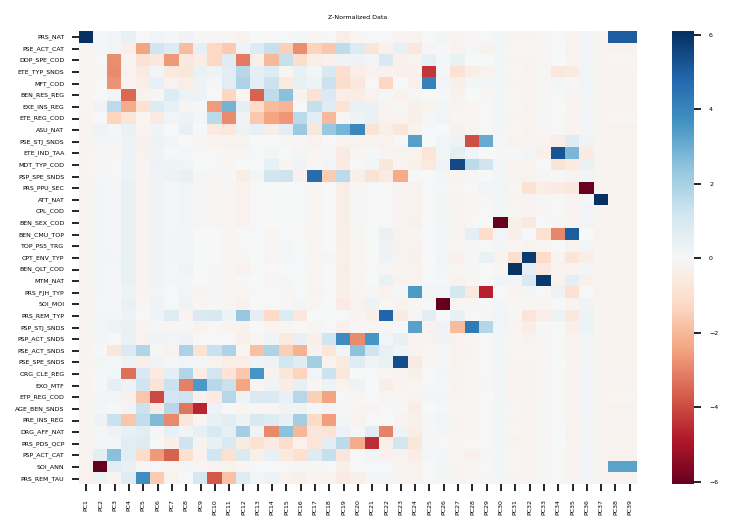

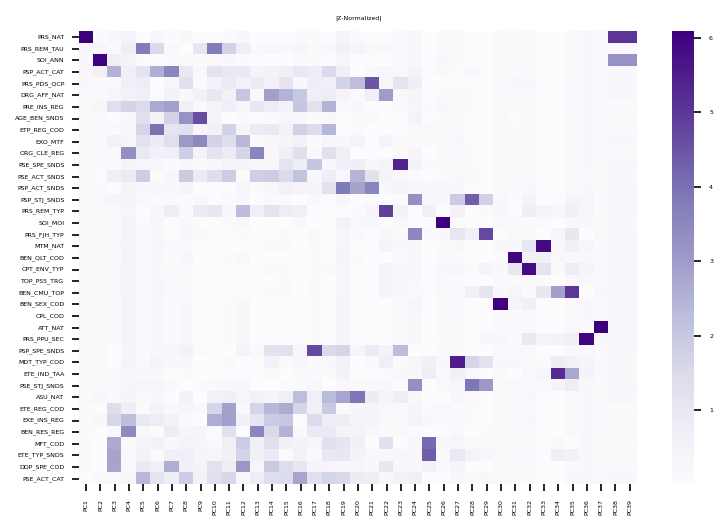

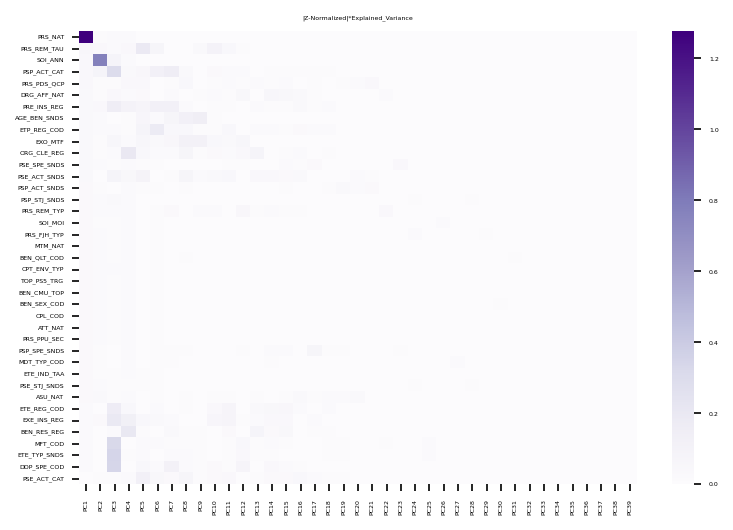

        score_      feature_
rank                        
1     1.404162       PRS_NAT
2     1.026402   PSP_ACT_CAT
3     0.985119       SOI_ANN
4     0.884164   PRE_INS_REG
5     0.872417   DDP_SPE_COD
6     0.829845   EXE_INS_REG
7     0.716407   ORG_CLE_REG
8     0.711795       EXO_MTF
9     0.700100  PSE_ACT_SNDS
10    0.686305   ETP_REG_COD
11    0.679022   PRS_REM_TAU
12    0.662919   PSE_ACT_CAT
13    0.662911  ETE_TYP_SNDS
14    0.659037       MFT_COD
15    0.656441   ETE_REG_COD
16    0.598229   BEN_RES_REG
17    0.559555  AGE_BEN_SNDS
18    0.528559   DRG_AFF_NAT
19    0.458774   PRS_PDS_QCP
20    0.400765   PRS_REM_TYP
21    0.388158       ASU_NAT
22    0.348977  PSP_SPE_SNDS
23    0.325307  PSE_SPE_SNDS
24    0.304431  PSP_ACT_SNDS
25    0.231495  PSP_STJ_SNDS
26    0.216664  PSE_STJ_SNDS
27    0.204865   MDT_TYP_COD
28    0.197746   PRS_FJH_TYP
29    0.183570       SOI_MOI
30    0.179315   CPT_ENV_TYP
31    0.174153   BEN_SEX_COD
32    0.173286   BEN_QLT_COD
33    0.170993

(           variance_cumulative      variance
 dimension                                   
 1                     0.209837  2.098367e-01
 2                     0.337949  1.281120e-01
 3                     0.459592  1.216434e-01
 4                     0.519471  5.987908e-02
 5                     0.570114  5.064242e-02
 6                     0.616222  4.610875e-02
 7                     0.659434  4.321118e-02
 8                     0.697690  3.825668e-02
 9                     0.730305  3.261492e-02
 10                    0.756883  2.657774e-02
 11                    0.782970  2.608732e-02
 12                    0.808036  2.506566e-02
 13                    0.831667  2.363099e-02
 14                    0.853575  2.190810e-02
 15                    0.874523  2.094800e-02
 16                    0.892143  1.761957e-02
 17                    0.907388  1.524588e-02
 18                    0.919069  1.168088e-02
 19                    0.929230  1.016037e-02
 20                    0.939198  9

In [39]:
pca_full_report(X=kinewonawoindic.to_numpy(), features_=kinewonawoindic.columns)

In [27]:
kinewonawoindic = kinewonawoindic[["DDP_SPE_COD","PRS_REM_TYP","EXO_MTF","EXE_INS_REG","ORG_CLE_REG","PRE_INS_REG","DRG_AFF_NAT","BEN_RES_REG","PRS_REM_TAU","AGE_BEN_SNDS","ETE_TYP_SNDS","MFT_COD","ETP_REG_COD","ETE_REG_COD","ASU_NAT","PSP_SPE_SNDS","PSP_STJ_SNDS","PSE_STJ_SNDS","PRS_FJH_TYP","SOI_MOI","CPT_ENV_TYP","PSE_ACT_SNDS"]]

## Standardize values

### Standard Scaler

In [40]:
scaler = StandardScaler()
scaler.fit(X_pca)
scaler.mean_
X_pca_scaled = scaler.transform(X_pca)
kinewonawoindic_scaled  = scaler.fit(kinewonawoindic).transform(kinewonawoindic)

### Robust Scaler (Gestion des valeurs abérantes)

In [41]:
transformer = RobustScaler().fit(X_pca)
X_pca_scaled_rb = transformer.transform(X_pca)

## Normalize values
### Normalizer

In [42]:
nrmlz = Normalizer(norm="max").fit(X_pca_scaled)
X_pca_scaled_and_normalized = nrmlz.transform(X_pca_scaled)

### Power Transformer

In [43]:
pt = PowerTransformer()
pt.fit(X_pca_scaled)
X_pca_scaled_pt = pt.transform(X_pca_scaled)

In [44]:
kinewonawoindic.head(5)

,ORG_CLE_REG,AGE_BEN_SNDS,BEN_RES_REG,BEN_CMU_TOP,BEN_QLT_COD,BEN_SEX_COD,DDP_SPE_COD,ETE_REG_COD,ETE_TYP_SNDS,ETP_REG_COD,MDT_TYP_COD,MFT_COD,PRS_FJH_TYP,SOI_ANN,SOI_MOI,ASU_NAT,ATT_NAT,CPL_COD,CPT_ENV_TYP,DRG_AFF_NAT,ETE_IND_TAA,EXO_MTF,MTM_NAT,PRS_NAT,PRS_PPU_SEC,PRS_REM_TAU,PRS_REM_TYP,PRS_PDS_QCP,EXE_INS_REG,PSE_ACT_SNDS,PSE_ACT_CAT,PSE_SPE_SNDS,PSE_STJ_SNDS,PRE_INS_REG,PSP_ACT_SNDS,PSP_ACT_CAT,PSP_SPE_SNDS,PSP_STJ_SNDS,TOP_PS5_TRG
0,76,50,99,0,1,1,121,99,99,99,9,99,0,2019,8,10,0,0,1,11,9,41,0,6112,2,0.0,0,0,99,0,99,0,9,76,0,1,1,1,1
1,76,80,76,0,1,2,121,99,99,99,9,99,8,2019,12,10,0,0,1,35,9,41,0,1451,2,70.0,0,31,76,19,4,0,9,76,19,4,0,9,1
2,75,80,75,0,1,2,121,99,99,99,9,99,0,2019,12,10,0,0,1,35,9,0,0,3533,2,60.0,0,31,75,60,2,0,1,52,0,1,15,1,1
3,24,50,24,0,1,1,121,99,99,99,9,99,0,2019,8,10,0,0,1,36,9,41,0,3533,2,60.0,0,31,24,60,2,0,1,24,0,1,15,1,1
4,5,20,5,1,1,2,60,5,1,99,1,3,0,2019,10,10,0,0,2,36,0,0,0,2237,1,0.0,0,31,99,0,0,0,2,99,0,99,0,9,1


In [45]:
f=pd.DataFrame(X_pca_scaled_and_normalized,columns=["x","y"])
f['c'] = kinewonawoindic.AGE_BEN_SNDS
f

,x,y,c
0,1.000000,-0.162476,50
1,-150.369888,1.000000,80
2,1.000000,-0.466217,80
3,1.000000,-0.502120,50
4,-3.614581,1.000000,20
...,...,...,...
9995,1.000000,-2.358772,80
9996,-3.340606,1.000000,70
9997,1.000000,-0.156865,30
9998,1.000000,-0.670726,0


Text(0.5, 1.0, 'Kine PCA :: Age')

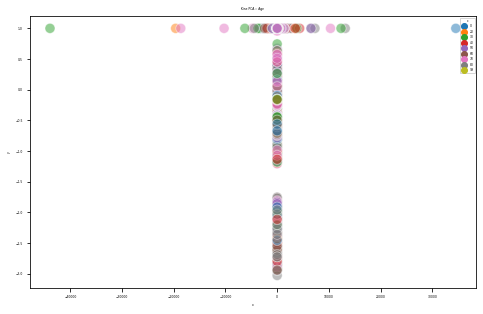

In [46]:
plt.figure(figsize=(8,5))
s = sns.scatterplot(
    x="x", y="y",
    hue="c",
    palette=sns.color_palette(sns.color_palette("tab10"), n_colors=9),
    data=f,
    s=100,
    legend="full",
    alpha=.5,
)
s.set_title("Kine PCA :: Age")

## Analyse TSNE

In [47]:
 X_embedded = TSNE(n_components=2, learning_rate=20, n_iter=1000, perplexity=64, n_jobs=-1).fit_transform(kinewonawoindic_scaled[0:100000])

### Sauvegarde du resultat

In [48]:
np.savetxt("tsne_kine.csv", X_embedded, delimiter=",")

### Récupération du résultat

In [50]:
X_embedded_loaded = np.loadtxt(open('tsne_kine.csv',"rb"), delimiter=",", skiprows=0)

### Vérification du chargement

In [51]:
X_embedded_loaded.shape

(10000, 2)

In [52]:
X_embedded.shape

(10000, 2)

In [53]:
X_embedded == X_embedded_loaded

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       ...,
       [ True,  True],
       [ True,  True],
       [ True,  True]])

### Visualisation du TSNE

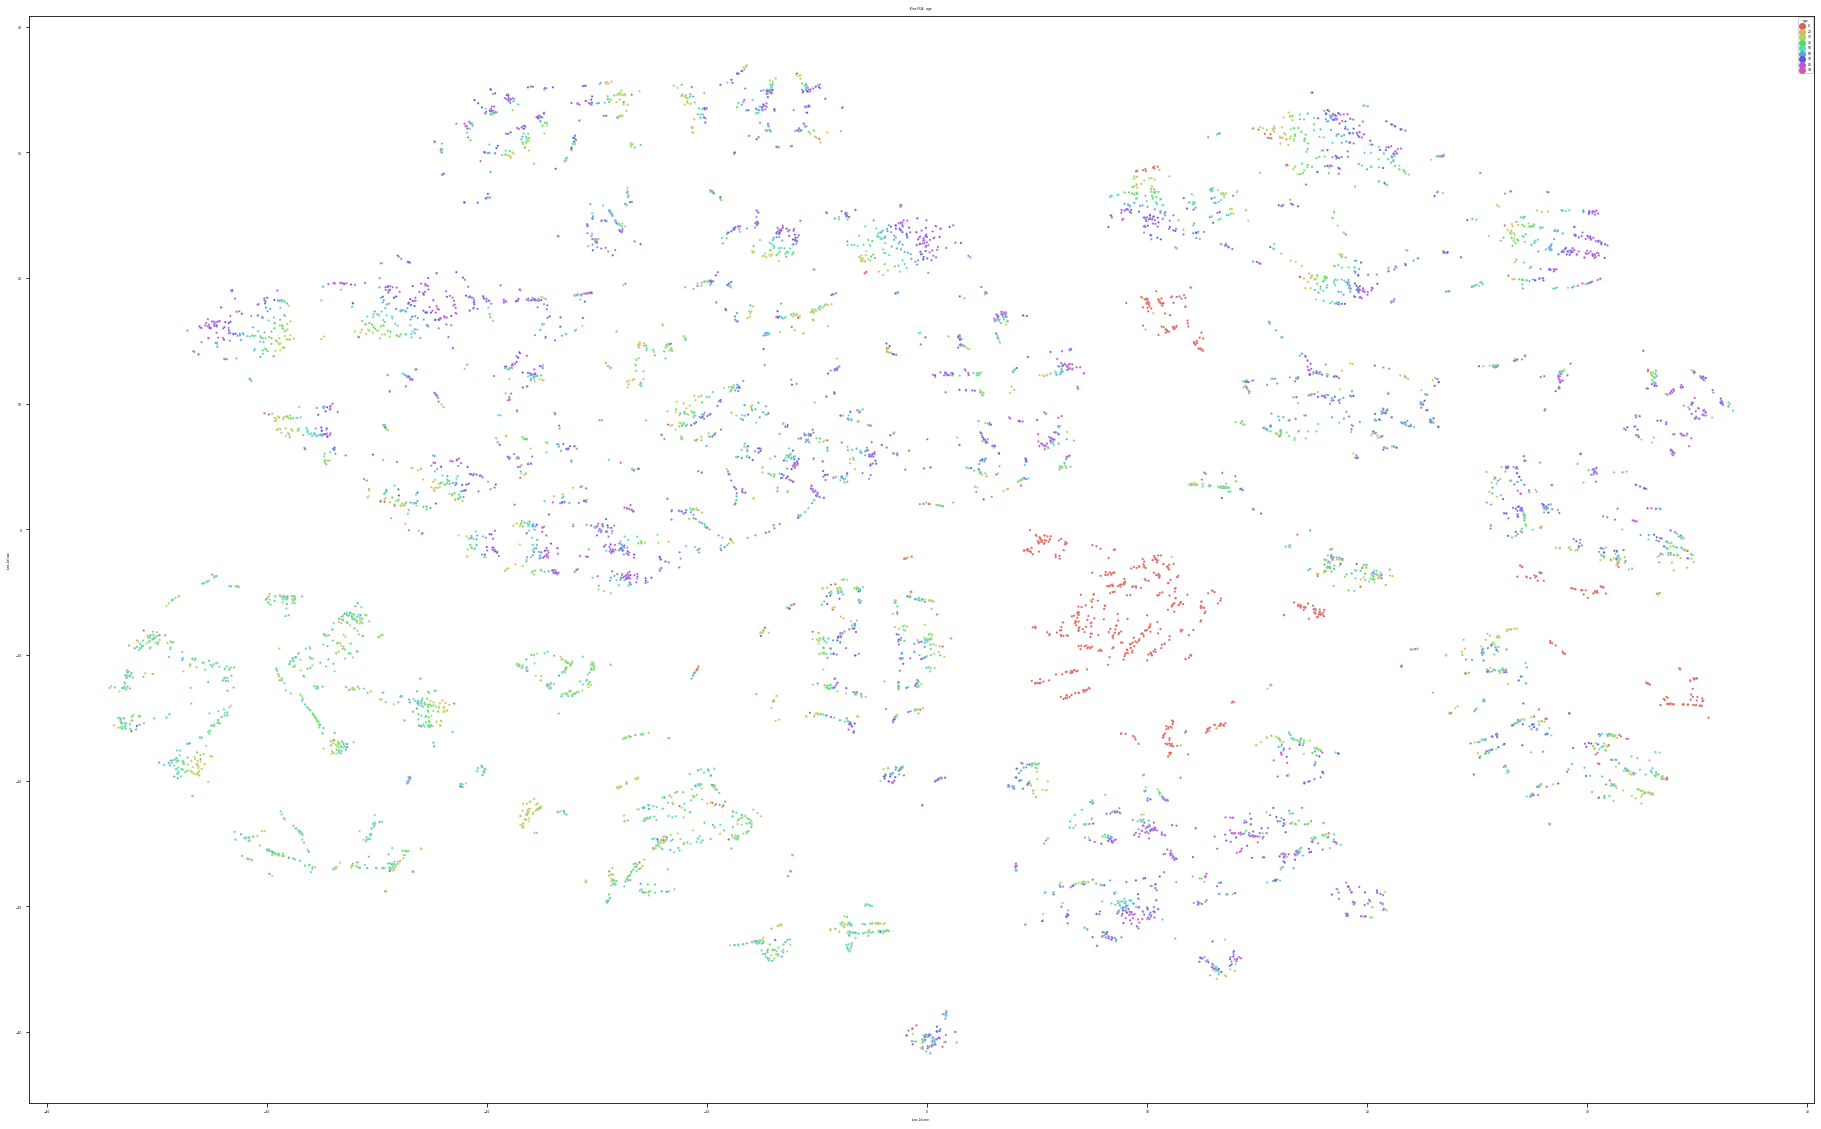

In [55]:
# my_colors = ['#fffffd00','#fffffe00','#ffffff00','#fffffc00','#990000','#992222']
f=pd.DataFrame()
f['tsne-2d-one'] = X_embedded[:,0]
f['tsne-2d-two'] = X_embedded[:,1]
f['age'] = kinewonawoindic.AGE_BEN_SNDS
plt.figure(figsize=(32,20))
s = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="age",
    palette=sns.color_palette("hls", n_colors=9),
    data=f,
    s=5,
    legend="full",
    alpha=1,
    edgecolors='none',
)
s.set_title("Kine PCA : age")
plt.savefig("kine-pca-age.png")

# Apprentissage supervisé

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.preprocessing import MinMaxScaler

from sklearn.experimental import enable_hist_gradient_boosting 

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import CategoricalNB

from sklearn.neural_network import MLPClassifier

## Preparation du jeu de données

### Jeux de données avec les ages inconnus

In [62]:
kine_age_unknow = kinewonawoindic[kine.AGE_BEN_SNDS == 99]
kine_age_unknow.head()

,ORG_CLE_REG,AGE_BEN_SNDS,BEN_RES_REG,BEN_CMU_TOP,BEN_QLT_COD,BEN_SEX_COD,DDP_SPE_COD,ETE_REG_COD,ETE_TYP_SNDS,ETP_REG_COD,MDT_TYP_COD,MFT_COD,PRS_FJH_TYP,SOI_ANN,SOI_MOI,ASU_NAT,ATT_NAT,CPL_COD,CPT_ENV_TYP,DRG_AFF_NAT,ETE_IND_TAA,EXO_MTF,MTM_NAT,PRS_NAT,PRS_PPU_SEC,PRS_REM_TAU,PRS_REM_TYP,PRS_PDS_QCP,EXE_INS_REG,PSE_ACT_SNDS,PSE_ACT_CAT,PSE_SPE_SNDS,PSE_STJ_SNDS,PRE_INS_REG,PSP_ACT_SNDS,PSP_ACT_CAT,PSP_SPE_SNDS,PSP_STJ_SNDS,TOP_PS5_TRG
1782,76,99,76,0,1,1,0,76,6,99,2,36,8,2019,11,10,0,0,1,35,0,42,0,3117,2,100.0,0,31,99,24,6,0,9,76,0,1,1,9,1
2457,93,99,99,0,1,0,121,99,99,99,9,99,0,2018,1,10,0,0,0,35,9,62,0,4370,2,100.0,0,0,93,0,6,99,8,99,0,99,0,9,1
6906,93,99,93,0,1,1,121,99,99,99,9,99,8,2019,11,10,0,0,1,35,9,42,0,1845,2,100.0,0,31,93,26,7,0,9,93,0,1,1,9,1
7072,93,99,93,0,1,1,121,99,99,99,9,99,8,2018,12,10,0,0,1,35,9,41,1,1812,2,100.0,0,31,93,24,6,0,9,93,0,1,1,9,1
8735,24,99,24,0,1,1,0,24,4,24,9,7,0,2019,9,10,0,0,2,35,2,62,0,2113,2,100.0,0,31,99,0,0,0,9,99,0,0,0,9,1


### Jeux de données avec les ages connus

In [63]:
kine_age_know = kinewonawoindic[kinewonawoindic.AGE_BEN_SNDS != 99]
kine_age_know.head()

,ORG_CLE_REG,AGE_BEN_SNDS,BEN_RES_REG,BEN_CMU_TOP,BEN_QLT_COD,BEN_SEX_COD,DDP_SPE_COD,ETE_REG_COD,ETE_TYP_SNDS,ETP_REG_COD,MDT_TYP_COD,MFT_COD,PRS_FJH_TYP,SOI_ANN,SOI_MOI,ASU_NAT,ATT_NAT,CPL_COD,CPT_ENV_TYP,DRG_AFF_NAT,ETE_IND_TAA,EXO_MTF,MTM_NAT,PRS_NAT,PRS_PPU_SEC,PRS_REM_TAU,PRS_REM_TYP,PRS_PDS_QCP,EXE_INS_REG,PSE_ACT_SNDS,PSE_ACT_CAT,PSE_SPE_SNDS,PSE_STJ_SNDS,PRE_INS_REG,PSP_ACT_SNDS,PSP_ACT_CAT,PSP_SPE_SNDS,PSP_STJ_SNDS,TOP_PS5_TRG
0,76,50,99,0,1,1,121,99,99,99,9,99,0,2019,8,10,0,0,1,11,9,41,0,6112,2,0.0,0,0,99,0,99,0,9,76,0,1,1,1,1
1,76,80,76,0,1,2,121,99,99,99,9,99,8,2019,12,10,0,0,1,35,9,41,0,1451,2,70.0,0,31,76,19,4,0,9,76,19,4,0,9,1
2,75,80,75,0,1,2,121,99,99,99,9,99,0,2019,12,10,0,0,1,35,9,0,0,3533,2,60.0,0,31,75,60,2,0,1,52,0,1,15,1,1
3,24,50,24,0,1,1,121,99,99,99,9,99,0,2019,8,10,0,0,1,36,9,41,0,3533,2,60.0,0,31,24,60,2,0,1,24,0,1,15,1,1
4,5,20,5,1,1,2,60,5,1,99,1,3,0,2019,10,10,0,0,2,36,0,0,0,2237,1,0.0,0,31,99,0,0,0,2,99,0,99,0,9,1


### Séparation du jeux d'apprentissage entre les variables(x) et la cible(y)

In [64]:
kine_X = kine_age_know[["DDP_SPE_COD","PRS_REM_TYP","EXO_MTF","EXE_INS_REG","ORG_CLE_REG","PRE_INS_REG","DRG_AFF_NAT","BEN_RES_REG","PRS_REM_TAU","ETE_TYP_SNDS","MFT_COD","ETP_REG_COD","ETE_REG_COD","ASU_NAT","PSP_SPE_SNDS","PSP_STJ_SNDS","PSE_STJ_SNDS","PRS_FJH_TYP","SOI_MOI","CPT_ENV_TYP","PSE_ACT_SNDS"]]

In [65]:
kine_Y = kine_age_know[["AGE_BEN_SNDS"]]

In [66]:
kine_X_age_unknow = kine_age_unknow[["PRS_PAI_MNT","ETP_CAT_SNDS","EXE_INS_REG","ORG_CLE_REG","DDP_SPE_COD","EXO_MTF","PRE_INS_REG","BEN_RES_REG","PRS_REM_TAU","PRS_REM_TYP","ETE_CAT_SNDS","ETP_REG_COD","DRG_AFF_NAT","PRS_ACT_QTE","ASU_NAT","PSP_SPE_SNDS","ETE_REG_COD","PSP_STJ_SNDS","PRS_FJH_TYP","PSE_STJ_SNDS","MFT_COD","ETE_TYP_SNDS"]]

KeyError: ignored

### Découpage des jeux en base d'apprentissage et de tests

In [67]:
kine_X_train, kine_X_test, kine_Y_train, kine_Y_test = train_test_split(kine_X.to_numpy(), kine_Y.to_numpy(), test_size=0.33, random_state=42) 

### Scaling data

In [68]:
scaler = StandardScaler()
scaler = RobustScaler()
kine_X_train_scaled  = scaler.fit(kine_X_train).transform(kine_X_train)
kine_X_test_scaled  = scaler.fit(kine_X_test).transform(kine_X_test)

## AdaBoost Classifier

In [69]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(kine_X_train, kine_Y_train).score(kine_X_test, kine_Y_test)

0.2594725674446802

In [70]:
clf.fit(kine_X_train_scaled, kine_Y_train).score(kine_X_test_scaled, kine_Y_test)

0.2546226129130039

## Bagging Classifier

In [71]:
clf = BaggingClassifier(base_estimator=SVC(), n_estimators=10, random_state=0, n_jobs=-1)

In [72]:
clf.fit(kine_X_train, kine_Y_train).score(kine_X_test, kine_Y_test)

0.26553501060927553

In [77]:
clf.fit(kine_X_train_scaled, kine_Y_train).score(kine_X_test_scaled, kine_Y_test)

0.24704455895725977

## Extra Trees Classifier

In [75]:
clf = ExtraTreesClassifier(n_estimators=9, random_state=0, n_jobs=-1)
clf.fit(kine_X_train, kine_Y_train).score(kine_X_test, kine_Y_test)

0.25098514701424673

In [76]:
clf.fit(kine_X_train_scaled, kine_Y_train).score(kine_X_test_scaled, kine_Y_test)

0.24704455895725977

## Gradient Boosting Classifier

In [78]:
clf = GradientBoostingClassifier(random_state=0)
clf.fit(kine_X_train, kine_Y_train).score(kine_X_test, kine_Y_test)

0.29190663837526526

In [79]:
clf.fit(kine_X_train_scaled, kine_Y_train).score(kine_X_test_scaled, kine_Y_test)

0.288269172476508

## Random Forest Classifier

In [80]:
clf = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=9, n_jobs=-1)
clf.fit(kine_X_train, kine_Y_train).score(kine_X_test, kine_Y_test)

0.2682631100333434

In [81]:
clf.fit(kine_X_train_scaled, kine_Y_train).score(kine_X_test_scaled, kine_Y_test)

0.25795695665353136

## Stacking Classifier 

In [82]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)),
    ('svr', make_pipeline(StandardScaler(),
                          LinearSVC(random_state=42)))
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
clf.fit(kine_X_train, kine_Y_train).score(kine_X_test, kine_Y_test)

AttributeError: ignored

## Voting Classifier

In [84]:
clf1 = LogisticRegression(multi_class='multinomial', random_state=1, n_jobs=-1)
clf2 = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
clf3 = GaussianNB()
eclf1 = VotingClassifier(estimators=[
    ('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
eclf1 = eclf1.fit(kine_X_train, kine_Y_train).score(kine_X_test, kine_Y_test)

AttributeError: ignored

In [85]:
eclf2 = VotingClassifier(estimators=[
                                    ('lr', clf1), 
                                    ('rf', clf2), 
                                    ('gnb', clf3)],
                         voting='soft')
eclf2 = eclf2.fit(kine_X_train, kine_Y_train).score(kine_X_test, kine_Y_test)

AttributeError: ignored

In [86]:
eclf3 = VotingClassifier(estimators=[
    ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
                         voting='soft', weights=[2,1,1],
                         flatten_transform=True)
eclf3 = eclf3.fit(kine_X_train, kine_Y_train).score(kine_X_test, kine_Y_test)

AttributeError: ignored

In [ ]:
eclf1, eclf2, eclf3

## History Gradient Boosting

In [87]:
clf = HistGradientBoostingClassifier()
clf.fit(kine_X_train, kine_Y_train).score(kine_X_test, kine_Y_test)

0.2934222491664141

In [88]:
clf.fit(kine_X_train_scaled, kine_Y_train).score(kine_X_test_scaled, kine_Y_test)

0.27796301909669596

## Complement Naive Bayesian Classifier 

In [89]:
clf = CategoricalNB()
scaler = MinMaxScaler()
kine_X_train_scaled  = scaler.fit(kine_X_train).transform(kine_X_train)
kine_X_test_scaled  = scaler.fit(kine_X_test).transform(kine_X_test)
clf.fit(kine_X_train_scaled, kine_Y_train).score(kine_X_test_scaled, kine_Y_test)
#clf.fit(kine_X_train, kine_Y_train).score(kine_X_test, kine_Y_test)

0.2240072749317975

## Categorical Naïve Bayesean Classifier

In [90]:
clf = ComplementNB()
scaler = MinMaxScaler()
kine_X_train_scaled  = scaler.fit(kine_X_train).transform(kine_X_train)
kine_X_test_scaled  = scaler.fit(kine_X_test).transform(kine_X_test)
clf.fit(kine_X_train_scaled, kine_Y_train).score(kine_X_test_scaled, kine_Y_test)

0.2197635647165808

## Multi-layer Perceptron classifier

In [91]:
clf = MLPClassifier(random_state=1, max_iter=1000, verbose=True, solver='sgd', learning_rate='adaptive', early_stopping=True).fit(kine_X_train, kine_Y_train)
clf.fit(kine_X_train_scaled, kine_Y_train).score(kine_X_test_scaled, kine_Y_test)
#clf.fit(kine_X_train, kine_Y_train).score(kine_X_test, kine_Y_test)

Iteration 1, loss = 15.07839467
Validation score: 0.128358
Iteration 2, loss = 2.10712308
Validation score: 0.161194
Iteration 3, loss = 2.05215858
Validation score: 0.161194
Iteration 4, loss = 2.01244119
Validation score: 0.156716
Iteration 5, loss = 1.99988197
Validation score: 0.149254
Iteration 6, loss = 1.99300734
Validation score: 0.165672
Iteration 7, loss = 1.98627957
Validation score: 0.159701
Iteration 8, loss = 1.98279684
Validation score: 0.158209
Iteration 9, loss = 1.97706936
Validation score: 0.165672
Iteration 10, loss = 1.97217126
Validation score: 0.159701
Iteration 11, loss = 1.97217206
Validation score: 0.171642
Iteration 12, loss = 1.96218042
Validation score: 0.170149
Iteration 13, loss = 1.95022004
Validation score: 0.192537
Iteration 14, loss = 1.93378861
Validation score: 0.205970
Iteration 15, loss = 1.92472226
Validation score: 0.204478
Iteration 16, loss = 1.91908343
Validation score: 0.197015
Iteration 17, loss = 1.91633322
Validation score: 0.198507
Itera

0.22431039709002729